<a href="https://colab.research.google.com/github/Omar-Ahmed-Kandel/Sprints-Project/blob/main/Sprints_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import make_scorer, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import PredefinedSplit



# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

y = y.apply(lambda x: 1 if x > 0 else 0)

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [4]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [5]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [6]:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

In [8]:
pca = PCA(n_components=0.95)
selector = SelectKBest(score_func=mutual_info_classif, k=10)

# **Supervised Models**

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

In [10]:

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", pca),
        ("selector", selector),
        ("classifier", model)
    ])

# **Train/Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **GridSearchCV**

In [12]:
param_grids = {
    "Logistic Regression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__solver": ["liblinear", "lbfgs"]
    },
    "Decision Tree": {
        "classifier__max_depth": [3, 5, 10, None],
        "classifier__min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [3, 5, 10, None]
    },
    "SVM": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf"]
    }
}

In [13]:
best_models = {}

for name, pipeline in pipelines.items():
    print(f"\n=== Training {name} with GridSearchCV ===")

    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_models[name] = grid
    print(f"Best Params for {name}: {grid.best_params_}")



=== Training Logistic Regression with GridSearchCV ===
Best Params for Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}

=== Training Decision Tree with GridSearchCV ===
Best Params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 5}

=== Training Random Forest with GridSearchCV ===
Best Params for Random Forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}

=== Training SVM with GridSearchCV ===
Best Params for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}



=== Logistic Regression Evaluation ===
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

ROC-AUC: 0.949134199134199

=== Decision Tree Evaluation ===
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        33
           1       0.88      0.75      0.81        28

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.83        61

ROC-AUC: 0.9264069264069266

=== Random Forest Evaluation ===
              precision    recall  f1-score   support

           0       0.84      0.79      0.81        33
           1       0.77      0.82      0.79        28

    accuracy       

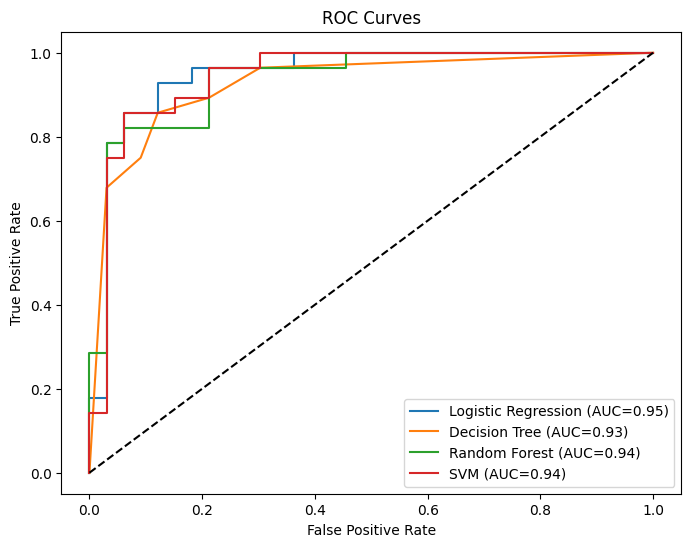

In [14]:
plt.figure(figsize=(8, 6))

for name, grid in best_models.items():
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} Evaluation ===")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [15]:
os.makedirs("models", exist_ok=True)

for name, grid in best_models.items():
    filename = f"models/{name.replace(' ', '_').lower()}_best.pkl"
    joblib.dump(grid.best_estimator_, filename)
    print(f"Saved {name} model to {filename}")

Saved Logistic Regression model to models/logistic_regression_best.pkl
Saved Decision Tree model to models/decision_tree_best.pkl
Saved Random Forest model to models/random_forest_best.pkl
Saved SVM model to models/svm_best.pkl


In [16]:
X_scaled = preprocessor.fit_transform(X)

In [17]:
s_scores = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    s_scores[k] = silhouette_score(X_scaled, labels)

In [18]:
best_k = max(s_scores, key=s_scores.get)
print("Best k (by silhouette score):", best_k)

Best k (by silhouette score): 2


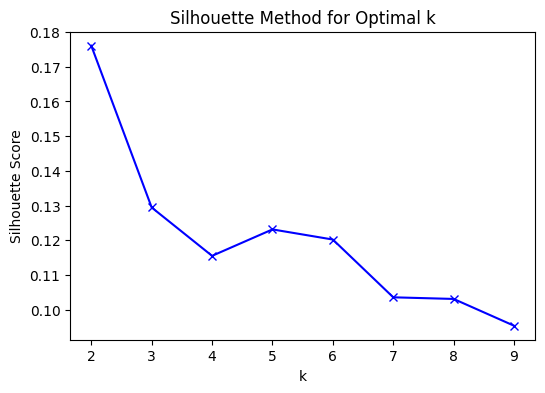

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(list(s_scores.keys()), list(s_scores.values()), "bx-")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()

In [20]:
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = final_kmeans.fit_predict(X_scaled)

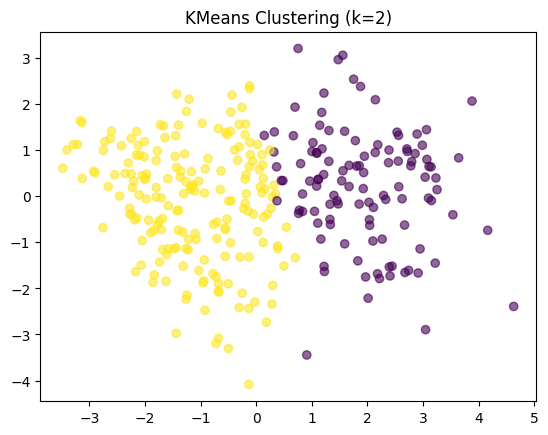

In [21]:
X_kmeans = PCA(n_components=2).fit_transform(X_scaled)
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=labels_kmeans, cmap="viridis", alpha=0.6)
plt.title(f"KMeans Clustering (k={best_k})")
plt.show()


In [22]:
df_kmeans = pd.DataFrame({"True_Label": y.values, "KMeans_Cluster": labels_kmeans})
print(df_kmeans.head())

   True_Label  KMeans_Cluster
0           0               0
1           1               0
2           1               0
3           0               1
4           0               1


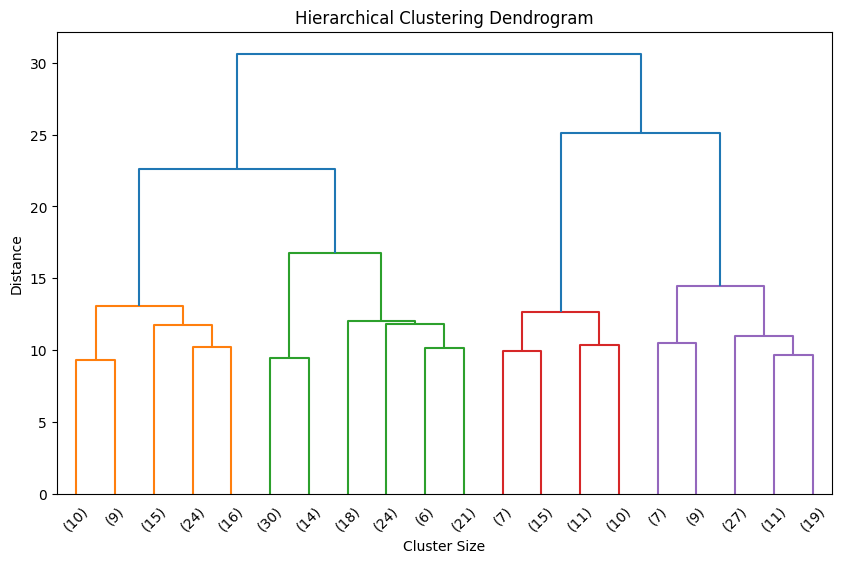

In [23]:
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="lastp", p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

In [24]:
hc = AgglomerativeClustering(n_clusters=2)
labels_hc = hc.fit_predict(X_scaled)

In [25]:
df_hc = pd.DataFrame({"True_Label": y.values, "Hierarchical_Cluster": labels_hc})
print(df_hc.head())

   True_Label  Hierarchical_Cluster
0           0                     0
1           1                     0
2           1                     0
3           0                     1
4           0                     1


In [26]:
os.makedirs("models", exist_ok=True)

joblib.dump(final_kmeans, "models/kmeans_best.pkl")

joblib.dump(hc, "models/hierarchical_best.pkl")

['models/hierarchical_best.pkl']